## Обзор доступных данных

В качестве данных мы будем использовать датасет, содержащий оценки пользователями товаров, представленных на платформе Amazon.

Обучающая выборка содержат следующие признаки:
<ul>
<li><strong>userId</strong> - ID пользователя </li>
<li><strong>productId</strong> - ID продукта </li>
<li><strong>Rating</strong> - оценка соответствующего продукта от соответствующего пользователя </li>
</ul>

В тестовой выборке отсутствует признак Rating.

Всего в выборке 42469 оценок, которые мы разбили на обучающую и тестовую части.  


# 1. Загрузить данные для обучения

## 1.1 Загружаем библиотеки

Для решения задачи нам понадобятся уже знакомые:
* библиотека **pandas** для работы с табличными данными (Excel, CSV и др.);
* библиотека **numpy** для обработки массивов чисел, с помощью которой можно быстро создавать массивы, производить над ними вычисления, сортировать и т.д.
* библиотека **matplotlib** для работы с двумерной и трехмерной графиков;

* библиотека **scikit-learn**, де-факто наиболее популярный, разносторонний, хорошо документированный и постоянно обогащающийся инструмент для построения моделей машинного обучения;

In [ ]:
import pandas as pd
import numpy as np

import matplotlib
%matplotlib inline

import sklearn

Отключим лишние предупреждения.

In [ ]:
import warnings; warnings.simplefilter('ignore')

Для создания алгоритмов рекомендательной системы, будем использовать библиотеку **surprise**.

Документация библиотеки доступна по ссылке http://surpriselib.com/.

In [ ]:
!pip install surprise

import surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163481 sha256=1c6bd84c4cc7031090b73cf23bef9f27b6ba96368d5a0592b4d3fce734f6d903
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


## 1.2. Загрузим данные



In [ ]:
%%capture
!wget https://www.dropbox.com/s/y5glirn7hi88don/train.csv
!wget https://www.dropbox.com/s/9ie39fr09lbfo52/test.csv

In [ ]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

Проверим, что данные загрузились правильно:

In [ ]:
train_data.head()

,userId,productId,Rating
0,AOPE42H34R0EC,B00000DM9W,5.0
1,A1GI09JC6L0NF7,B00004SABJ,4.0
2,AZLZII4AFX56R,B00000J579,3.0
3,A34AHNT6GD9FWW,9888002198,5.0
4,A2PXRAO5C1XTLW,0972683275,5.0


Проверим размерность данных:

In [ ]:
train_data.shape

(33975, 3)

## 1.3. Первичный анализ данных

Проверим типы в данных и количество NaN-ов:

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33975 entries, 0 to 33974
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   userId     33975 non-null  object 
 1   productId  33975 non-null  object 
 2   Rating     33975 non-null  float64
dtypes: float64(1), object(2)
memory usage: 796.4+ KB


Найдём минимальный и максимальные рейтинги:


In [ ]:
print('Minimum rating is: %d' %(train_data.Rating.min()))
print('Maximum rating is: %d' %(train_data.Rating.max()))

Minimum rating is: 1
Maximum rating is: 5


Посмотрим на распределение рейтингов:

<Axes: >

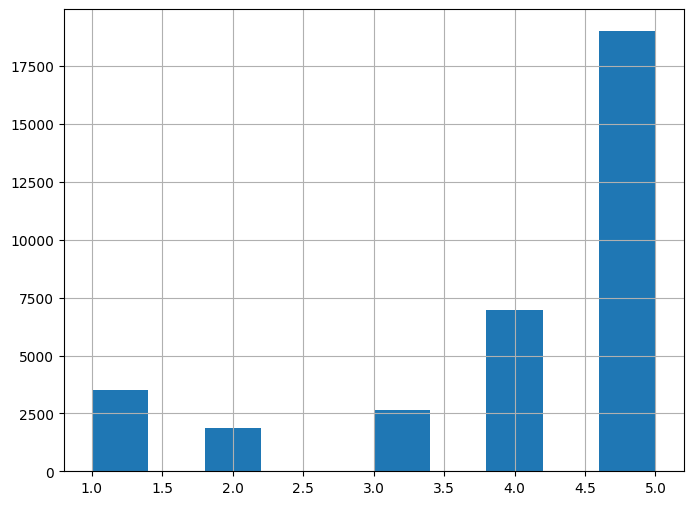

In [ ]:
train_data.Rating.hist(figsize=(8, 6))

Пользователи часто ставят оценку 5.

**Упражнение:** сколько уникальных пользователей в выборке, а товаров?

In [ ]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Rating,33975.0,4.063135,1.333392,1.0,4.0,5.0,5.0,5.0


In [ ]:
train_data.userId.nunique()


32384

**Упражнение:** сколько оценок в среднем делает пользователь?

In [ ]:
train_data.groupby(['userId', 'Rating'])['userId'].count().head()

userId                 Rating
A001944026UMZ8T3K5QH1  1.0       1
A00766851QZZUBOVF4JFT  5.0       1
A014623426J5CM7M12MBW  5.0       1
A01580702BRW77PSJ9X34  1.0       1
A01852072Z7B68UHLI5UG  4.0       1
Name: userId, dtype: int64

### 2. Обучить модель

### Алгоритм KNN. Коллаборативная фильтрация по схожести пользователей

Из библиотеки **surprise** импортируем специальный классы **Reader, Dataset**, которые позволят удобнее работать с данными.

In [ ]:
from surprise import Reader
from surprise import Dataset

In [ ]:
reader = Reader(sep=',', rating_scale=(1, 5))
train = Dataset.load_from_df(train_data, reader)
train = train.build_full_trainset()

В качестве baseline рассмотрим KNN, который использует схожесть **товаров** по косинусной метрике.

In [ ]:
from surprise import KNNBasic
from surprise import accuracy

In [ ]:
algo = KNNBasic(k=3, sim_options={'name': 'cosine', 'user_based': False})
algo.fit(train)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [ ]:
# run the trained model against the testset
test_pred = algo.test(test_data[['userId', 'productId', 'Rating']].values)

In [ ]:
def prepare_surprise_predictoin_for_kaggle(test_pred):
  key_list = []
  rate_list = []

  for i in range(0, len(test_pred)):
    key_list.append((test_pred[i][0], test_pred[i][1]))
    rate_list.append(test_pred[i][3])

  predictions = pd.DataFrame(np.transpose([key_list, rate_list]), columns=['Keys', 'Predicted rating'])
  return predictions

In [ ]:
pred_data = prepare_surprise_predictoin_for_kaggle(test_pred)
pred_data = pred_data.rename(columns={'Predicted rating': 'Rating'})

In [ ]:
pred_data.to_csv('predictions.csv', index=False)

# Идеи для дальнейшей работы:

**1. Попробовать другие расстояния для модели**

Для коллаборативной фильтрации можно попробовать различные расстояния: косинусное, корреляции Пирсона итд.

**2. Попробовать другие модели**

Мы рассмотрели только одну модель user-based коллаборативной фильтрации. Рассмотрите item-based коллаборативную фильтрацию, алгоритм SVD.

**3. Подобрать параметры модели**
Можно использовать метод GridSearch из библиотеки surprise.
